In [440]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [441]:
from torchvision import transforms

from Net.source.utils.common_utils import plot_figures, torch2cv
from Net.source.hpatches_dataset import HPatchesDataset, PhotometricAugmentation, ResizeItem, CropItem, FinishAugmentation, IMAGE1, IMAGE2, S_IMAGE1, S_IMAGE2, HOMO12, HOMO21
from Net.experiments.config import AnalyzeDatasetConfig

In [442]:
dataset_config = AnalyzeDatasetConfig().get()

item_transforms = [PhotometricAugmentation(brightness=None, contrast=None),
                   ResizeItem((960, 1280)),
                   ResizeItem((dataset_config.HEIGHT, dataset_config.WIDTH)),
                   FinishAugmentation(dataset_config.DATASET_MEAN, dataset_config.DATASET_STD)]

dataset = HPatchesDataset(dataset_config.DATASET_ROOT,
                          dataset_config.CSV,
                          item_transforms=transforms.Compose(item_transforms),
                          include_sources=dataset_config.INCLUDE_SOURCES)

In [443]:
item = dataset.__getitem__(0)

image1 = item[IMAGE1]
image2 = item[IMAGE2]

homo12 = item[HOMO12]
homo21 = item[HOMO21]

s_image1 = item[S_IMAGE1]
s_image2 = item[S_IMAGE2]

In [444]:
from Net.source.utils.image_utils import warp_image

w_image1 = warp_image(image2.unsqueeze(0), image1.unsqueeze(0), homo21.unsqueeze(0)).squeeze(0)
w_image2 = warp_image(image1.unsqueeze(0), image2.unsqueeze(0), homo12.unsqueeze(0)).squeeze(0)

In [445]:
cv_image1 = torch2cv(image1, to_rgb=True)
cv_image2 = torch2cv(image2, to_rgb=True)

cv_s_image1 = torch2cv(s_image1)
cv_s_image2 = torch2cv(s_image2)

cv_w_image1 = torch2cv(w_image1, to_rgb=True)
cv_w_image2 = torch2cv(w_image2, to_rgb=True)

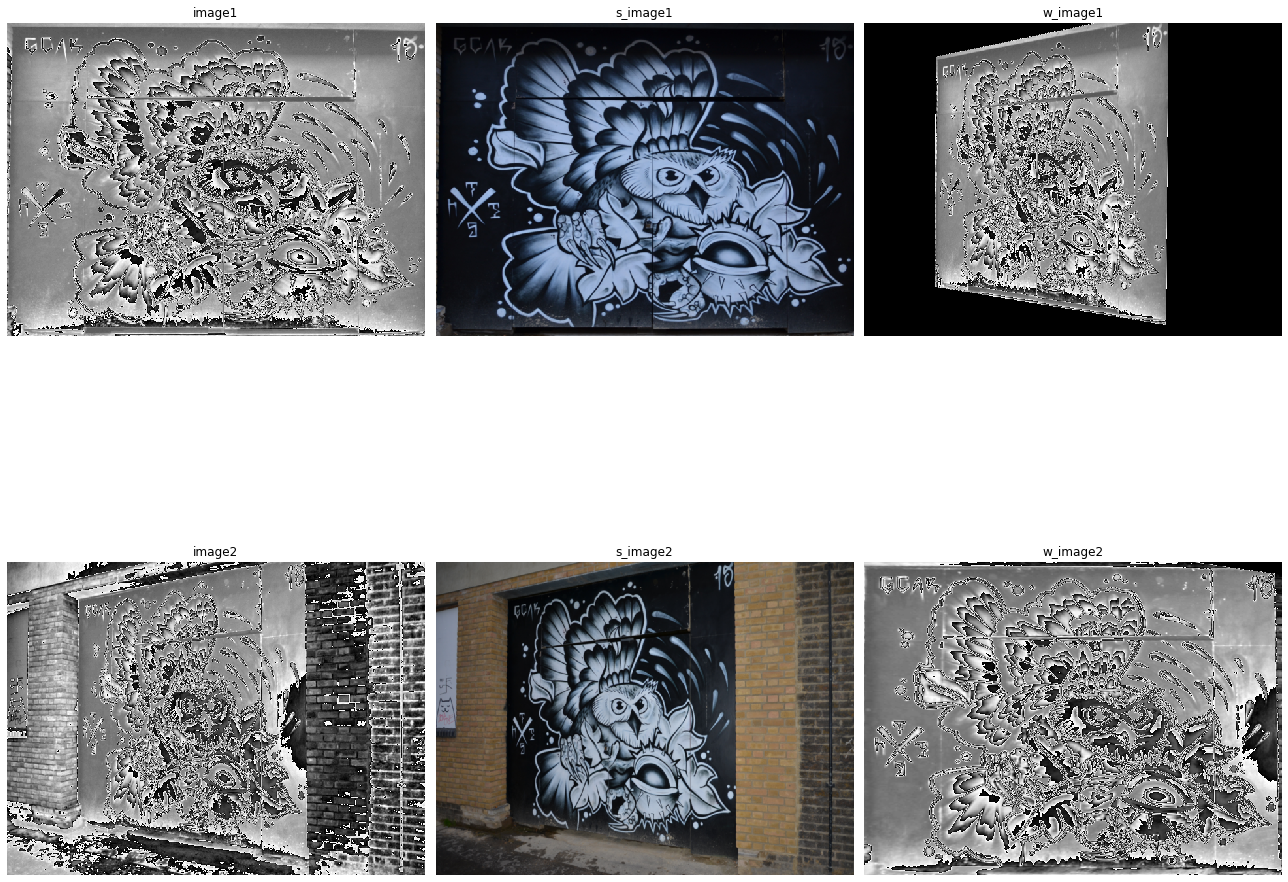

In [446]:
plot_figures({'image1': cv_image1, 's_image1': cv_s_image1, 'w_image1': cv_w_image1,
              'image2': cv_image2, 's_image2': cv_s_image2, 'w_image2': cv_w_image2}, 2, 3, (18, 18))